In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
import multiprocessing as mp
import time
import glob
import re
import random
from sklearn.model_selection import train_test_split
import torch

sys.path.insert(0, '/Data/user/panhailin/git_lab/npspy')
import npspy as nps
from npspy import npsc

# 全局配置

In [3]:
# torch.set_num_threads(10)

# all_peps = [
#      '1A', '1C', '1D', '1E', '1F', '1G', '1H', '1I', '1K', '1L', '1M', '1N', '1P', '1Q', '1R', '1S', '1T', '1V', '1W', '1Y',
# ]
# y_code_dict = nps.ml.set_y_codes_for_classes(np.array(all_peps)[:,None])
# y_code_dict
# y_to_label_dict = {v:k for k,v in y_code_dict.items()}
# y_code_dict, y_to_label_dict

torch.set_num_threads(10)

all_peps = [['1K', '1R'], ['1D', '1E'], ['1F', '1W', '1Y', '1I', '1L', '1M', '1V', '1H', '1Q', '1A', '1G', '1S', '1C', '1P', '1T', '1N']]

y_code_dict = nps.ml.set_y_codes_for_classes(all_peps)
y_code_dict
y_to_label_dict = {0: 'positive', 1: 'negative', 2: 'neutral'}
print(y_code_dict)
print(y_to_label_dict)

tmp = []
for i in all_peps:
    tmp.extend(i)
all_peps = tmp
all_peps

{'1K': 0, '1R': 0, '1D': 1, '1E': 1, '1F': 2, '1W': 2, '1Y': 2, '1I': 2, '1L': 2, '1M': 2, '1V': 2, '1H': 2, '1Q': 2, '1A': 2, '1G': 2, '1S': 2, '1C': 2, '1P': 2, '1T': 2, '1N': 2}
{0: 'positive', 1: 'negative', 2: 'neutral'}


['1K',
 '1R',
 '1D',
 '1E',
 '1F',
 '1W',
 '1Y',
 '1I',
 '1L',
 '1M',
 '1V',
 '1H',
 '1Q',
 '1A',
 '1G',
 '1S',
 '1C',
 '1P',
 '1T',
 '1N']

In [4]:
test_objs = [f"../../../00.data/GSXGS/{pep}_valid20.pkl" for pep in all_peps]
labels = all_peps

In [5]:
def stratified_sample(df, column_name, sample_size=15000, random_state=42):
    """
    对DataFrame按指定列类别分层随机抽样
    
    参数:
        df: 输入DataFrame
        column_name: 分层依据的列名
        sample_size: 每类抽取样本数(默认15000)
        random_state: 随机种子
    
    返回:
        抽样后的新DataFrame
    """
    re_df = df.groupby(column_name, group_keys=True).apply(
        lambda x: x.sample(min(len(x), sample_size), 
                          random_state=random_state),
        include_groups=False,
    )
    re_df[re_df.index.names[0]] =  [i[0] for i in re_df.index]
    re_df.index = [i[1] for i in re_df.index]
    return re_df

In [6]:
valid20_clean_rejected_pred_df = pd.read_csv('../../../04.tables/classification_for_real_data/GSXGS/valid20_clean_or_rejected.csv', index_col=0)
valid20_clean_rejected_pred_df = valid20_clean_rejected_pred_df[valid20_clean_rejected_pred_df['pred'] == 'clean']
tmp_objs = []
for pep, one_obj_file in zip(all_peps, test_objs):
    print(f'===={pep}====')
    one_obj = nps.io.read_pickle(one_obj_file)
    one_obj = nps.tl.extract_reads_as_an_obj(one_obj, np.intersect1d(valid20_clean_rejected_pred_df.index, list(one_obj.keys())))
    tmp_objs.append(one_obj)
    print(len(one_obj))
test_objs = tmp_objs

====1K====
20038
====1R====
9402
====1D====
11759
====1E====
8602
====1F====
4952
====1W====
3779
====1Y====
3344
====1I====
21522
====1L====
18150
====1M====
4729
====1V====
7467
====1H====
3812
====1Q====
10597
====1A====
7353
====1G====
9283
====1S====
4232
====1C====
2756
====1P====
10709
====1T====
4896
====1N====
5927


# 读取pkl文件，生成readid，X，y组成的df

In [7]:
test_df = nps.ml.get_X_y_from_objs(objs=test_objs, labels=labels, y_code_dict=y_code_dict, down_sample_to=1000, att='signal')
test_df = stratified_sample(test_df, 'y', sample_size=6000, random_state=42)

# 通过data_df构建dataloader

In [8]:
batch_size = 64
test_dl = nps.ml.construct_dataloader_from_data_df(test_df, batch_size=batch_size, shuffle=False)

# predict

In [9]:
nps.ml.seed_everything(42)
clf = nps.ml.Trainer(lr=0.005, num_classes=len(y_to_label_dict), epochs=200, device='cuda', lr_scheduler_patience=3, label_smoothing=0.1, model_name='CNN1DL1000')

Model CNN1DL1000 has total parameter number: 6.21 M


In [10]:
pred_df = clf.predict(test_dl, name='clean_data_large_group', y_to_label_dict=y_to_label_dict)
pred_proba_df = clf.predict_proba(test_dl, name='clean_data_large_group',)
pred_proba_df.to_csv("../../../04.tables/classification_for_real_data/GSXGS/cls_large_groups_pred_proba.csv")
cm_df = nps.ml.get_cm(pred_df, label_order=y_to_label_dict.values())
cm_df.to_csv("../../../04.tables/classification_for_real_data/GSXGS/cls_large_groups_cm.csv")
print(cm_df)
print(np.sum(np.diag(cm_df))/len(pred_df))

 test_acc: 0.9318
 test_acc: 0.9318
pred      positive  negative  neutral
true                                 
positive      5658        64      278
negative        50      5658      292
neutral        228       316     5456
0.9317777777777778


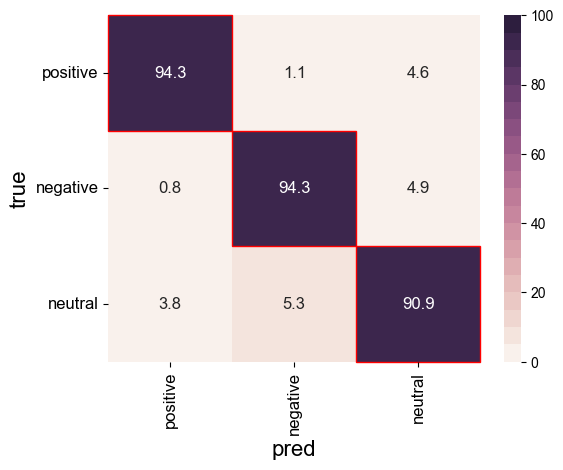

In [11]:
plt.rcParams['axes.labelsize'] = 16
nps.ml.plot_cm(cm_df, figsize=(6,4.5), nor_to_percent_for_each_pred=True, annot_size=12.0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('../../../05.figures/classification_for_real_data/GSXGS/large_groups_cm.pdf', bbox_inches='tight')